## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
# Rows given by RangeIndex: entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('landing_page == "new_page"').query('group != "treatment"').count() \
    + df.query('landing_page != "new_page"').query('group == "treatment"').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
# None of the rows have missing values.
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.drop(df.query('landing_page == "new_page"').query('group != "treatment"').index, axis=0)

In [9]:
df2 = df2.drop(df2.query('landing_page != "new_page"').query('group == "treatment"').index, axis=0)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop(df2[df2.user_id.duplicated()].index)

In [15]:
df2.count()

user_id         290584
timestamp       290584
group           290584
landing_page    290584
converted       290584
dtype: int64

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2.query('landing_page == "new_page"').user_id.count() / df2.user_id.count()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**There isn't enough evidence to say the treatment group has a higher conversion rate. In fact, the treatment group actually had a smaller proportion of conversions than the control group. With this info alone, we fail to reject the null hypothesis $H_0$**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_0: p_{new} \leq p_{old}$

$H_1: p_{new} > p_{old}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
# Under the null, both p_new and p_old are equal, which means they're equal to the total converted rate.
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new = (df.landing_page == 'new_page').sum()
n_new

147239

d. What is $n_{old}$?

In [23]:
n_old = (df.landing_page == 'old_page').sum()
n_old

147239

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice(df.converted.unique(), size=n_new, p=[1-p_new, p_new]).mean()
new_page_converted

0.1192482969865321

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice(df.converted.unique(), size=n_old, p=[1-p_old, p_old]).mean()
old_page_converted

0.120728882972582

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted - old_page_converted

-0.001480585986049901

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice(df.converted.unique(), size=n_new, p=[1-p_new, p_new]).mean()
    old_page_converted = np.random.choice(df.converted.unique(), size=n_old, p=[1-p_old, p_old]).mean()
    p_diffs.append(new_page_converted - old_page_converted)

p_diffs = np.array(p_diffs)
p_diffs.mean()

-3.3347143080308674e-07

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [28]:
# Observed difference in conversion rate.
obs_diff = df2.query('landing_page == "new_page"').converted.mean() - df2.query('landing_page == "old_page"').converted.mean()

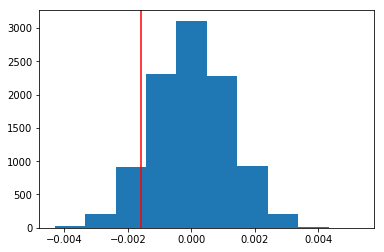

In [29]:
plt.hist(p_diffs);
plt.axvline(obs_diff, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
(p_diffs > obs_diff).mean()

0.9081

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In part j, I found that 90.81% of our simulated differences were higher than the observed difference. This value *0.9081* is called a p-value and indicates the probability that our null hypothesis is true.** 

**With an $\alpha$ of *0.05* and a p-value of *0.9081*, we fail to reject the null hypothesis. In other words, there wasn't a significant increase in the conversion rate of the new landing page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == "1"').count()[0]
convert_new = df2.query('landing_page == "new_page" and converted == "1"').count()[0]
n_old = (df.landing_page == 'old_page').sum()
n_new = (df.landing_page == 'new_page').sum()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.2851562063649145, 0.9006311481555165)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [33]:
from scipy.stats import norm

# Find critical value at 95% confidence for one-sided z-test.
norm.ppf(1-(0.05))

1.6448536269514722

**A z-score is defined as the number of standard deviations ($\sigma$) away from the mean ($\mu$) that a certain data point is. For a one-sided z-test, our 95% confidence interval is ($-\infty$, 1.64), meaning that any z-score over 1.64 will be significant. For a 95% confidence interval on our p-value, any value less than our $\alpha$ 0.05 is statistically significant.**

**Our measured z-score of 1.28 and our p-value is 0.9006 are within the ranges we'd expect under our null hypothesis, so we fail to reject the null.** 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since the data is categorical, I'll be using logistic regression to analyze it.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
# Add intercept column
df2['intercept'] = 1

In [35]:
# Add dummy variable column 'ab_page' where treatment is represented by a 1 and control is represented by a 0
df2['ab_page'] = pd.get_dummies(df2.group, drop_first=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
log_mod = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 07 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        02:25:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Using logistic regression, the new p-value is 0.190. This value is different from the p-value found in Part II, because logistic regression uses a two-tailed confidence interval.**

**The null & alternative hypothesis tests under this model are:**

$H_0: p_{new} = p_{old}$

$H_1: p_{new} \neq p_{old}$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Additional factors could greatly improve the accuracy of the model. Factors such as the country of origin, the day of the week, the time of day, etc. could all prove useful in the model. However, it's important to watch out for multicollinearity between x-variables. Having x-variables that are too correlated with one another can destabilize the regression coefficients.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [39]:
df_new.groupby('country').converted.mean()

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

**At first glance, it looks like there may be a relationship between country and conversion rates. Before giving a definitve answer, we'll need to confirm that these small differences in conversion rate are statistically significant.**

In [40]:
### Create the necessary dummy variables
df_new = df_new.join(pd.get_dummies(df_new.country, drop_first=True))

In [41]:
log_mod = sm.Logit(df_new.converted, df_new[['intercept', 'UK', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 07 Oct 2018   Pseudo R-squ.:               1.521e-05
Time:                        02:25:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**As seen above, none of our p-values are below 0.05. We fail to reject the null hypothesis.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new.converted, df_new[['intercept', 'ab_page', 'UK', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 07 Oct 2018   Pseudo R-squ.:               2.323e-05
Time:                        02:26:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**Just as we saw previously, there isn't a statistically significant difference in conversion rates for any of the countries looked at. We fail to reject the null hypothesis yet again.**

<a id='conclusions'></a>
## Conclusions

My analysis didn't show a statisticaly significant difference in conversion rates for any of the factors looked at. Without positive results, the company should keep their old landing page and continue testing others. Assuming advertising costs in each country are the same, they should allocate their budget based on the population of each country since none of them stood out as clear winner. They may want to try tailoring landing pages towards specific audiences on future tests. 

### Resources
* https://classroom.udacity.com
* https://stackoverflow.com/
* https://stackexchange.com/
* https://www.statsmodels.org/dev/index.html